In [ ]:
#############################################

In [1]:
import numpy as np
import open3d as o3d

def load_and_visualize_point_cloud(file_path):
    """
    Load and visualize point cloud data from a .npy file.
    
    Parameters:
        file_path (str): Path to the .npy file containing point cloud data.
    """
    # Load the point cloud data from the .npy file
    point_cloud_data = np.load(file_path)
    print(f'Number of points in the point cloud: {point_cloud_data.shape[0]}')

    # Create an Open3D PointCloud object
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(point_cloud_data)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([cloud])

# Replace with the actual path to your .npy file
file_path = r'C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\Subtile_tvm\subtile_7.npy'
load_and_visualize_point_cloud(file_path)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Number of points in the point cloud: 192086


Original number of points: 192086
Number of points after outlier removal: 186065


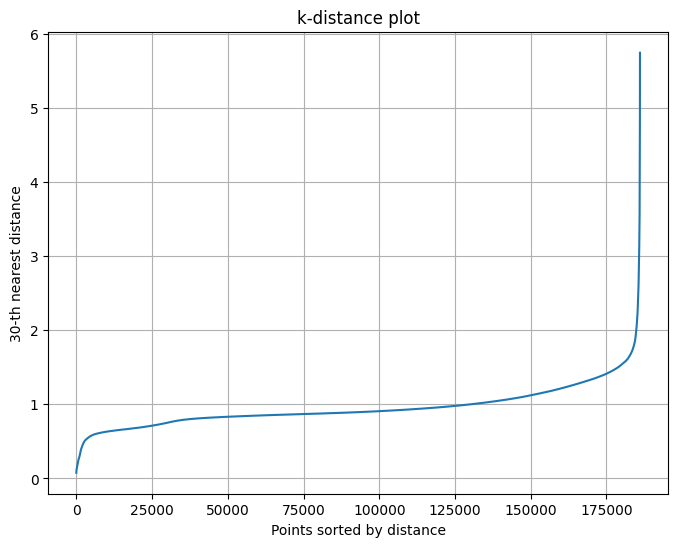

Estimated eps value: 1.301575967729609
Number of clusters found: 194


C:\Users\akhil\AppData\Local\Temp\ipykernel_8164\3302949940.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


In [2]:
import numpy as np
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def load_point_cloud(file_path):
    """
    Load point cloud data from a .npy file.
    """
    point_cloud_data = np.load(file_path)
    return point_cloud_data

def remove_outliers(point_cloud_data, nb_neighbors=20, std_ratio=2.0):
    """
    Removes outliers using statistical outlier removal.

    Parameters:
        point_cloud_data (np.ndarray): Input point cloud data.
        nb_neighbors (int): Number of neighbors to analyze for each point.
        std_ratio (float): Standard deviation ratio threshold.

    Returns:
        np.ndarray: Denoised point cloud data.
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud_data)
    
    # Apply statistical outlier removal
    clean_pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    
    return np.asarray(clean_pcd.points)

def k_distance_plot(point_cloud_data, k=30):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(point_cloud_data)
    distances, _ = neighbors.kneighbors(point_cloud_data)
    distances = np.sort(distances[:, -1], axis=0)
    
    plt.figure(figsize=(8, 6))
    plt.plot(distances)
    plt.title('k-distance plot')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th nearest distance')
    plt.grid(True)
    plt.show()
    
    return distances

def visualize_segmented_objects(point_cloud_data, labels):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    unique_labels = set(labels)
    colors = plt.cm.get_cmap('tab20', len(unique_labels))
    
    for label in unique_labels:
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(point_cloud_data[labels == label])
        color = colors(label / len(unique_labels))
        cloud.paint_uniform_color(color[:3])
        vis.add_geometry(cloud)
    
    vis.run()
    vis.destroy_window()

# Load point cloud
file_path = r"C:\Users\akhil\OneDrive\Documents\3D wireframe reconstruction\Subtile_tvm\subtile_7.npy"
point_cloud_data = load_point_cloud(file_path)
print(f"Original number of points: {point_cloud_data.shape[0]}")

# Remove outliers
point_cloud_data = remove_outliers(point_cloud_data)
print(f"Number of points after outlier removal: {point_cloud_data.shape[0]}")

# k-distance plot
distances = k_distance_plot(point_cloud_data, k=30)
eps = distances[int(len(distances) * 0.9)]
print(f"Estimated eps value: {eps}")

# Apply DBSCAN
min_samples = 60
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(point_cloud_data)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters found: {n_clusters}")

# Visualize clusters
visualize_segmented_objects(point_cloud_data, labels)


In [46]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

# Compactness: Calculate the average distance between points within each cluster
def compactness_score(point_cloud_data, labels):
    unique_labels = set(labels)
    compactness = 0
    for label in unique_labels:
        if label != -1:  # Exclude noise points
            cluster_points = point_cloud_data[labels == label]
            centroid = np.mean(cluster_points, axis=0)
            distances = np.linalg.norm(cluster_points - centroid, axis=1)
            compactness += np.mean(distances)
    
    return compactness / len(unique_labels) if len(unique_labels) > 1 else 0

# Separation: Calculate the average distance between centroids of different clusters
def separation_score(point_cloud_data, labels):
    unique_labels = set(labels)
    centroids = []
    
    for label in unique_labels:
        if label != -1:  # Exclude noise points
            cluster_points = point_cloud_data[labels == label]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
    
    # Calculate pairwise distances between centroids
    centroids = np.array(centroids)
    separation = np.mean(cdist(centroids, centroids, metric='euclidean'))
    
    return separation

# Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters
def silhouette_score_func(point_cloud_data, labels):
    # Ensure there are at least 2 clusters
    if len(set(labels)) > 1:
        return silhouette_score(point_cloud_data, labels)
    else:
        return -1  # Silhouette score is not defined for a single cluster

# Compute and print the metrics
compactness = compactness_score(point_cloud_data, labels)
separation = separation_score(point_cloud_data, labels)
silhouette = silhouette_score_func(point_cloud_data, labels)

print(f"Compactness Score: {compactness}")
print(f"Separation Score: {separation}")
print(f"Silhouette Score: {silhouette}")


Compactness Score: 2.3970620791316626
Separation Score: 53.27467797954906
Silhouette Score: -0.20445663020547045


In [3]:
import numpy as np
import open3d as o3d

def classify_objects(objects):
    """
    Classify objects based on simple geometric features.
    
    Parameters:
        objects (dict): A dictionary of segmented objects.
    
    Returns:
        dict: A dictionary with object IDs as keys and class labels as values.
    """
    classified_objects = {}
    
    for obj_id, obj_points in objects.items():
        # Calculate basic features for classification (e.g., height)
        height = np.max(obj_points[:, 2]) - np.min(obj_points[:, 2])
        
        # Simple heuristic: classify based on height (e.g., high = 1, low = 0)
        if height > 2:  # Arbitrary threshold for classification
            classified_objects[obj_id] = 'high'
        else:
            classified_objects[obj_id] = 'low'
    
    return classified_objects

# Convert labels into a dictionary format for classification
objects = {}
unique_labels = set(labels)
for label in unique_labels:
    if label != -1:  # Skip noise points (-1)
        objects[label] = point_cloud_data[labels == label]

# Classify segmented objects
classified_objects = classify_objects(objects)

# Visualize the classified objects
def visualize_classified_objects(objects, classified_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    for obj_id, obj_points in objects.items():
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(obj_points)
        
        # Set color based on classification
        color = [0, 0, 1] if classified_objects[obj_id] == 'high' else [1, 0, 0]  # Blue for 'high', red for 'low'
        cloud.paint_uniform_color(color)
        
        vis.add_geometry(cloud)
    
    vis.run()
    vis.destroy_window()



# Call the visualization function
visualize_classified_objects(objects, classified_objects)


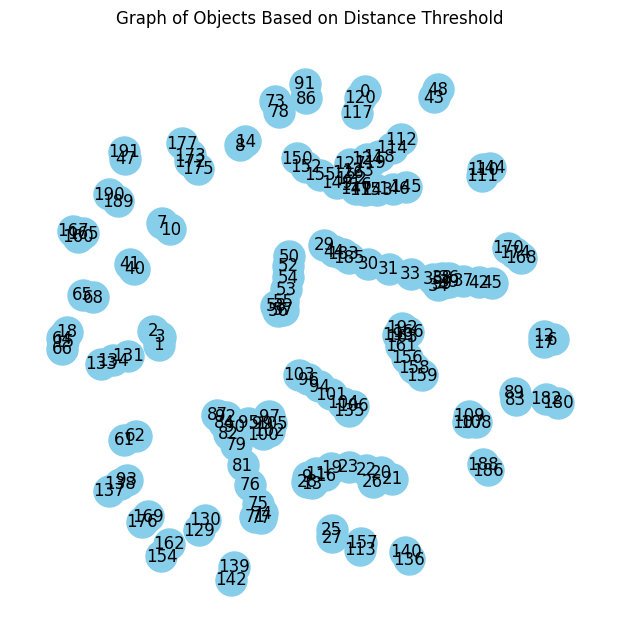

In [4]:
import numpy as np
import open3d as o3d
import networkx as nx
import matplotlib.pyplot as plt

def construct_graph(objects, threshold=10):
    """
    Constructs a graph where each object is a node, and an edge exists between two objects
    if they are within a certain threshold distance from each other.

    Parameters:
        objects (dict): A dictionary of objects (segmented point clouds).
        threshold (float): The distance threshold to consider objects as neighbors.

    Returns:
        dict: An adjacency list representing the graph.
    """
    graph = {}
    for obj_id, obj_points in objects.items():
        graph[obj_id] = []
        for other_obj_id, other_obj_points in objects.items():
            if obj_id != other_obj_id:
                # Compute the distance between the centroids of the objects
                distance = np.linalg.norm(np.mean(obj_points, axis=0) - np.mean(other_obj_points, axis=0))
                if distance < threshold:  # Check if objects are within the threshold distance
                    graph[obj_id].append(other_obj_id)
    
    return graph

# Construct the graph after the classification step
graph = construct_graph(objects)

# Visualize the graph
def visualize_graph(graph):
    """
    Visualizes the constructed graph using NetworkX.
    
    Parameters:
        graph (dict): An adjacency list representing the graph.
    """
    # Create a NetworkX graph from the adjacency dictionary
    G = nx.Graph()

    # Add edges to the graph
    for obj_id, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(obj_id, neighbor)

    # Create a layout for the graph
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, edge_color='gray')
    plt.title("Graph of Objects Based on Distance Threshold")
    plt.show()

# Visualize the constructed graph
visualize_graph(graph)




In [5]:
def merge_objects(graph, energy_func):
    """
    Merges objects based on the minimum energy calculated between object pairs.

    Parameters:
        graph (dict): Adjacency list representing the graph of objects.
        energy_func (function): A function that calculates energy between two objects.

    Returns:
        dict: Updated dictionary of merged objects.
    """
    merged_objects = objects.copy()  # Copy the original objects to preserve them

    while True:
        min_energy = float('inf')
        best_pair = None

        # Iterate over all pairs of objects to calculate the energy
        for obj_id1 in list(merged_objects.keys()):
            for obj_id2 in graph.get(obj_id1, []):
                if obj_id1 != obj_id2 and obj_id2 in merged_objects:
                    obj1_points = merged_objects[obj_id1]
                    obj2_points = merged_objects[obj_id2]

                    # Calculate the energy between the two objects
                    energy = energy_func(obj1_points, obj2_points)

                    # Update the best pair if a lower energy is found
                    if energy < min_energy:
                        min_energy = energy
                        best_pair = (obj_id1, obj_id2)

        # Merge the best pair if a pair was found
        if best_pair:
            obj_id1, obj_id2 = best_pair
            merged_objects[obj_id1] = np.concatenate([merged_objects[obj_id1], merged_objects[obj_id2]], axis=0)
            del merged_objects[obj_id2]  # Remove the second object from the dictionary

            # Update the graph to remove references to the merged object
            for obj_id in graph.keys():
                if obj_id2 in graph[obj_id]:
                    graph[obj_id].remove(obj_id2)
        else:
            # Exit the loop when no more pairs can be merged
            break

    return merged_objects



In [6]:
import numpy as np

def energy_function(obj1_points, obj2_points, weight=1):
    """
    Calculate the energy between two point cloud objects based on a simplified formulation
    of data, weight, and smoothness terms.
    
    Parameters:
        obj1_points (np.ndarray): Point cloud data of the first object.
        obj2_points (np.ndarray): Point cloud data of the second object.
        weight (float): Weight parameter for the energy terms.
        
    Returns:
        float: The computed energy value between the two objects.
    """
    # Data term: Euclidean distance between centroids (representing likelihood of merging)
    centroid1 = np.mean(obj1_points, axis=0)
    centroid2 = np.mean(obj2_points, axis=0)
    data_term = np.linalg.norm(centroid1 - centroid2)
    
    # Weight term: Penalty based on the size or other feature of the objects (prior)
    size1 = len(obj1_points)
    size2 = len(obj2_points)
    weight_term = weight * (size1 + size2)  # Adjust based on application needs
    
    # Smoothness term: Difference in height or other vertical property between objects
    height_diff = abs((np.max(obj1_points[:, 2]) - np.min(obj1_points[:, 2])) -
                      (np.max(obj2_points[:, 2]) - np.min(obj2_points[:, 2])))
    smoothness_term = height_diff
    
    # Total energy computation
    energy = data_term + weight_term + smoothness_term
    return energy

# Example usage within the merging function:
# merged_objects = merge_objects(graph, energy_function)
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Assuming `objects` is a dictionary of segmented point clouds from previous steps

# Merge objects using the energy function
merged_objects = merge_objects(graph, energy_function)

# Print the total number of segments after merging
print(f"Total number of segments after merging: {len(merged_objects)}")

# Visualize the result after merging objects
def visualize_merged_objects(merged_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    # Assign unique colors for each merged object
    color_map = plt.cm.get_cmap('tab20', len(merged_objects))
    
    for obj_id, obj_points in merged_objects.items():
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(obj_points)
        
        # Assign a color based on the object ID
        color = color_map(obj_id / len(merged_objects))[:3]  # Normalize ID for color map
        cloud.paint_uniform_color(color)
        
        vis.add_geometry(cloud) 

    vis.run()
    vis.destroy_window()

# Call the visualization function
visualize_merged_objects(merged_objects)



Total number of segments after merging: 97


C:\Users\akhil\AppData\Local\Temp\ipykernel_8164\881067095.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(merged_objects))


In [6]:
import open3d as o3d
import matplotlib.pyplot as plt

def visualize_segments_one_by_one(merged_objects):
    # Loop through each merged object and visualize it individually
    for obj_id, obj_points in merged_objects.items():
        # Create a PointCloud object for the current cluster
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(obj_points)
        
        # Assign a color for the object based on the object ID
        color_map = plt.cm.get_cmap('tab20', len(merged_objects))
        color = color_map(obj_id / len(merged_objects))[:3]  # Normalize ID for color map
        cloud.paint_uniform_color(color)
        
        # Create a visualization window for each segment
        vis = o3d.visualization.Visualizer()
        vis.create_window(window_name=f"Segment {obj_id + 1}")
        vis.add_geometry(cloud)
        
        # Display the segment
        vis.run()
        vis.destroy_window()

# Assuming `merged_objects` is a dictionary containing segmented point clouds
visualize_segments_one_by_one(merged_objects)


C:\Users\akhil\AppData\Local\Temp\ipykernel_15960\1396778248.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(merged_objects))


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLF

In [13]:
import open3d as o3d
import matplotlib.pyplot as plt
import os
import random

def visualize_and_save_segments(merged_objects, output_folder="Trivandrum_clusters_subtile_7"):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Randomly select 10 cluster IDs for visualization
    all_ids = list(merged_objects.keys())
    if len(all_ids) <= 10:
        selected_ids = all_ids
    else:
        selected_ids = random.sample(all_ids, 10)

    # Set up color map
    color_map = plt.cm.get_cmap('tab20', len(merged_objects))

    for obj_id, obj_points in merged_objects.items():
        # Create point cloud
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(obj_points)

        # Assign color
        color = color_map(obj_id / len(merged_objects))[:3]
        cloud.paint_uniform_color(color)

        # Visualize only if in selected list
        if obj_id in selected_ids:
            vis = o3d.visualization.Visualizer()
            vis.create_window(window_name=f"Segment {obj_id + 1}")
            vis.add_geometry(cloud)
            vis.run()
            vis.destroy_window()

        # Save all clusters
        save_path = os.path.join(output_folder, f"cluster_{obj_id + 1}.ply")
        o3d.io.write_point_cloud(save_path, cloud)
        print(f"Saved: {save_path}")

# Example usage:
visualize_and_save_segments(merged_objects)


C:\Users\akhil\AppData\Local\Temp\ipykernel_15960\3849986911.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(merged_objects))


Saved: Trivandrum_clusters_subtile_7\cluster_1.ply
Saved: Trivandrum_clusters_subtile_7\cluster_2.ply
Saved: Trivandrum_clusters_subtile_7\cluster_3.ply
Saved: Trivandrum_clusters_subtile_7\cluster_5.ply
Saved: Trivandrum_clusters_subtile_7\cluster_6.ply
Saved: Trivandrum_clusters_subtile_7\cluster_7.ply
Saved: Trivandrum_clusters_subtile_7\cluster_8.ply
Saved: Trivandrum_clusters_subtile_7\cluster_9.ply
Saved: Trivandrum_clusters_subtile_7\cluster_10.ply
Saved: Trivandrum_clusters_subtile_7\cluster_16.ply
Saved: Trivandrum_clusters_subtile_7\cluster_17.ply
Saved: Trivandrum_clusters_subtile_7\cluster_21.ply
Saved: Trivandrum_clusters_subtile_7\cluster_25.ply
Saved: Trivandrum_clusters_subtile_7\cluster_26.ply
Saved: Trivandrum_clusters_subtile_7\cluster_30.ply
Saved: Trivandrum_clusters_subtile_7\cluster_31.ply
Saved: Trivandrum_clusters_subtile_7\cluster_33.ply
Saved: Trivandrum_clusters_subtile_7\cluster_34.ply
Saved: Trivandrum_clusters_subtile_7\cluster_35.ply
Saved: Trivandrum_cl

In [39]:
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

def compute_compactness(points, labels):
    """
    Compute compactness of clusters: Average Euclidean distance between points and their centroid within each cluster.
    
    Parameters:
        points (np.ndarray): Array of points in the point cloud (n_samples x n_features).
        labels (np.ndarray): Cluster labels for each point.
        
    Returns:
        float: Average compactness score.
    """
    unique_labels = np.unique(labels)
    compactness_scores = []
    
    for label in unique_labels:
        if label == -1:  # Skip noise points
            continue
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        compactness_score = np.mean(np.linalg.norm(cluster_points - centroid, axis=1))
        compactness_scores.append(compactness_score)
    
    return np.mean(compactness_scores)

def compute_separation(points, labels):
    """
    Compute separation between clusters: Average distance between centroids of different clusters.
    
    Parameters:
        points (np.ndarray): Array of points in the point cloud (n_samples x n_features).
        labels (np.ndarray): Cluster labels for each point.
        
    Returns:
        float: Separation score.
    """
    unique_labels = np.unique(labels)
    centroids = []
    
    for label in unique_labels:
        if label == -1:  # Skip noise points
            continue
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
    
    if len(centroids) < 2:
        return 0  # No separation if there is only one cluster
    
    centroids = np.array(centroids)
    separation_score = np.mean(cdist(centroids, centroids, 'euclidean'))
    
    return separation_score

# Example usage within the clustering step:
# Assuming `merged_objects` contains the clustered point clouds
# Flatten the merged point clouds into one array for evaluation
all_points = np.vstack(list(merged_objects.values()))  # Stack all points from merged objects
labels = np.concatenate([np.full(len(obj_points), obj_id) for obj_id, obj_points in merged_objects.items()])

# Compute metrics
compactness = compute_compactness(all_points, labels)
separation = compute_separation(all_points, labels)
silhouette = silhouette_score(all_points, labels)

# Print the metrics
print(f"Compactness Score: {compactness}")
print(f"Separation Score: {separation}")
print(f"Silhouette Score: {silhouette}")


Compactness Score: 4.371932659951339
Separation Score: 103.30898394566027
Silhouette Score: 0.4328383022462698
